## import data and libraries

In [128]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

device = "cuda" if torch.cuda.is_available() else "cpu"

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GPU memory: 4.3 GB


In [129]:
class ModelNetCustomDataset(Dataset):
    def __init__(self, train: bool, classes=None, debug=True):
        self.debug = debug
        
        if train:
            x = torch.load("./data/ModelNet_subset/train_x.pt", weights_only=True)
            y = torch.load("./data/ModelNet_subset/train_y.pt", weights_only=True)
        else:
            x = torch.load("./data/ModelNet_subset/test_x.pt", weights_only=True)
            y = torch.load("./data/ModelNet_subset/test_y.pt", weights_only=True)

        # Load class names
        raw_dir = "./data/ModelNet/raw"
        self.class_names = sorted([
            name for name in os.listdir(raw_dir)
            if os.path.isdir(os.path.join(raw_dir, name))
        ])

        # Initialize mappings
        self.class_mapping = None
        self.reverse_mapping = None
        self.original_classes = classes

        if self.debug:
            print(f"Original data shapes: x={x.shape}, y={y.shape}")
            print(f"Original label range: [{y.min()}, {y.max()}]")
            print(f"Classes to filter: {classes}")

        # Filter classes FIRST, then standardize the filtered data
        if classes is not None:
            x, y = self.filter_classes(x, y, classes)
            
            if self.debug:
                print(f"After filtering: x={x.shape}, y={y.shape}")
                print(f"Filtered label range: [{y.min()}, {y.max()}]")

            # Create mapping from original class IDs to new contiguous IDs
            self.class_mapping = {original_id: new_id for new_id, original_id in enumerate(sorted(classes))}
            self.reverse_mapping = {new_id: original_id for original_id, new_id in self.class_mapping.items()}
            
            if self.debug:
                print(f"Class mapping: {self.class_mapping}")
            
            # Remap class IDs to be contiguous [0, 1, 2, ..., len(classes)-1]
            y = self.remap_classes(y)
            
            if self.debug:
                print(f"After remapping: label range [{y.min()}, {y.max()}]")
                print(f"Expected range: [0, {len(classes)-1}]")

        # Apply standardization to the (potentially filtered) data
        self.x = self.standardise(x)
        self.y = y
        
        if self.debug:
            print(f"Final dataset: x={self.x.shape}, y={self.y.shape}")
            print(f"Final label range: [{self.y.min()}, {self.y.max()}]")
        
    def remap_classes(self, y):
        """Remap original class IDs to contiguous range [0, 1, 2, ...]"""
        y_remapped = torch.zeros_like(y)
        for i in range(len(y)):
            original_class = y[i].item()
            if original_class not in self.class_mapping:
                raise ValueError(f"Class {original_class} not found in mapping {self.class_mapping}")
            new_class = self.class_mapping[original_class]
            y_remapped[i] = new_class
        return y_remapped

    def standardise(self, x):
        standardised_data = torch.zeros_like(x)
        for i in range(x.shape[0]):
            obj = x[i]
            mean_x = obj.mean(dim=0)
            std_x = obj.std()
            standardised_data[i] = (obj - mean_x) / (std_x + 1e-8)
        return standardised_data

    def filter_classes(self, x, y, classes):
        indices_to_keep = []
        for idx in range(len(y)):
            if y[idx].item() in classes:
                indices_to_keep.append(idx)
        
        if len(indices_to_keep) == 0:
            raise ValueError(f"No samples found for classes {classes}")
        
        x_selected = torch.index_select(x, dim=0, index=torch.tensor(indices_to_keep))
        y_selected = torch.index_select(y, dim=0, index=torch.tensor(indices_to_keep))
        return x_selected, y_selected

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        point_cloud = self.x[idx]
        class_id = self.y[idx]

        # Get original class name using reverse mapping
        if self.reverse_mapping is not None:
            original_class_id = self.reverse_mapping[class_id.item()]
            label = self.class_names[original_class_id]
        else:
            label = self.class_names[class_id.item()]
        
        return point_cloud, class_id, label

## steps

In [130]:
def accuracy_fn(y_pred,y_true):
    """
    Calculate accuracy of predictions
    Args:
        y_pred: Predictions from model (logits)
        y_true: True labels
    Returns:
        Accuracy as a percentage
    """
    # Get predicted class indices by taking argmax along the last dimension
    y_pred_indices = torch.argmax(y_pred, dim=1)
    
    # Compare with true labels and calculate accuracy
    correct = (y_pred_indices == y_true).sum().item()
    total = y_true.size(0)
    
    return correct / total * 100  # Return accuracy as percentage

In [131]:
def train_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        optimiser: torch.optim.Optimizer,
        accuracy_fn,
        device: torch.device = device,
        verbose: bool=True):

    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    
    #print(f"training loop on {device}...")
    
    for batch, (X, y, names) in enumerate(data_loader):
        
        try:
            # Move data to device
            X, y = X.to(device), y.to(device)
            
            # Fix label shape
            if y.dim() > 1:
                y = y.squeeze()
            y=y.long()

            # Forward pass
            y_pred = model(X)
            
            # Loss and accuracy
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_pred, y)
            
            train_loss += loss.item()
            train_acc += acc
            
            # Backward
            optimiser.zero_grad()
            loss.backward()
            
            # Update
            optimiser.step()

            # if batch % 400 == 0:
            #     print(f"TRAIN: Processed {batch * len(X)}/{len(data_loader.dataset)} samples")
            
        except Exception as e:
            print(f"   Error in batch {batch + 1}: {e}")
            import traceback
            traceback.print_exc()
            break
    
    # Calculate averages
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if verbose == True:
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc


In [132]:
def test_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        accuracy_fn,
        device: torch.device = device,
        verbose: bool=True
):
        test_loss, test_acc = 0, 0
        model.to(device)
        model.eval()  # Set model to evaluation mode
        with torch.inference_mode():  # No gradients needed for inference
            try:
                for batch, (X, y, names) in enumerate(data_loader):
                    X, y = X.to(device), y.to(device)

                    if y.dim() > 1:
                        y = y.squeeze()  # Converts [64, 1] to [64]
                    y=y.long()
                    
                    y_pred = model(X)

                    loss = loss_fn(y_pred, y)
                    acc = accuracy_fn(y_pred, y)

                    test_loss += loss.item()
                    test_acc += acc

                    # if batch % 400 == 0:
                    #     print(f"Processed {batch * len(X)}/{len(data_loader.dataset)} samples")
            except Exception as e:
                print(f"   Error in batch {batch + 1}: {e}")
                import traceback
                traceback.print_exc()

            # Average loss per batch per epoch
            test_loss /= len(data_loader)
            test_acc /= len(data_loader)
            if verbose == True:
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
        return test_loss, test_acc

In [133]:
def train_model(model,epochs, verbose = True):
    train_accs,test_accs,train_losses,test_losses=[],[],[],[]
    loss_fn= nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=5e-4)  # Added weight decay for regularisation

    # Use tqdm only if verbose is True
    epoch_iterator = tqdm(range(epochs)) if verbose else range(epochs)
    
    for epoch in epoch_iterator:
        if verbose:
            print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train step
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimiser=optimiser,
            accuracy_fn=accuracy_fn,
            device=device,
            verbose=verbose
        )
        
        # Test step
        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device,
            verbose=verbose
        )
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    if not verbose:
        print(f"Final: Train Acc: {train_accs[-1]:.2f}%, Test Acc: {test_accs[-1]:.2f}%")
    
    
    return train_accs, test_accs, train_losses, test_losses


In [134]:
def plot_acc_losses(
        model_name: str,
        train_accs: list,
        test_accs: list,
        train_losses: list,
        test_losses: list,
        epochs: int = 7
):
        f,(ax1,ax2)=plt.subplots(1,2)
        f.set_size_inches(15,5)
        ax1.plot(np.arange(1,epochs+1,1),test_accs,label="Test Accuracies")
        ax1.plot(np.arange(1,epochs+1,1),train_accs, label="Train Accuracies")
        ax1.set_title(f"{model_name} Accuracies")
        ax1.legend()
        ax1.set_ylabel("Accuracies (%)")
        ax1.set_xlabel("Epochs")

        ax2.plot(np.arange(1,epochs+1,1),test_losses, label="Test Losses")
        ax2.plot(np.arange(1,epochs+1,1),train_losses, label="Train Losses")
        ax2.set_title(f"{model_name} Losses")
        ax2.legend()
        ax2.set_ylabel("Losses")
        ax2.set_xlabel("Epochs")
    

## models

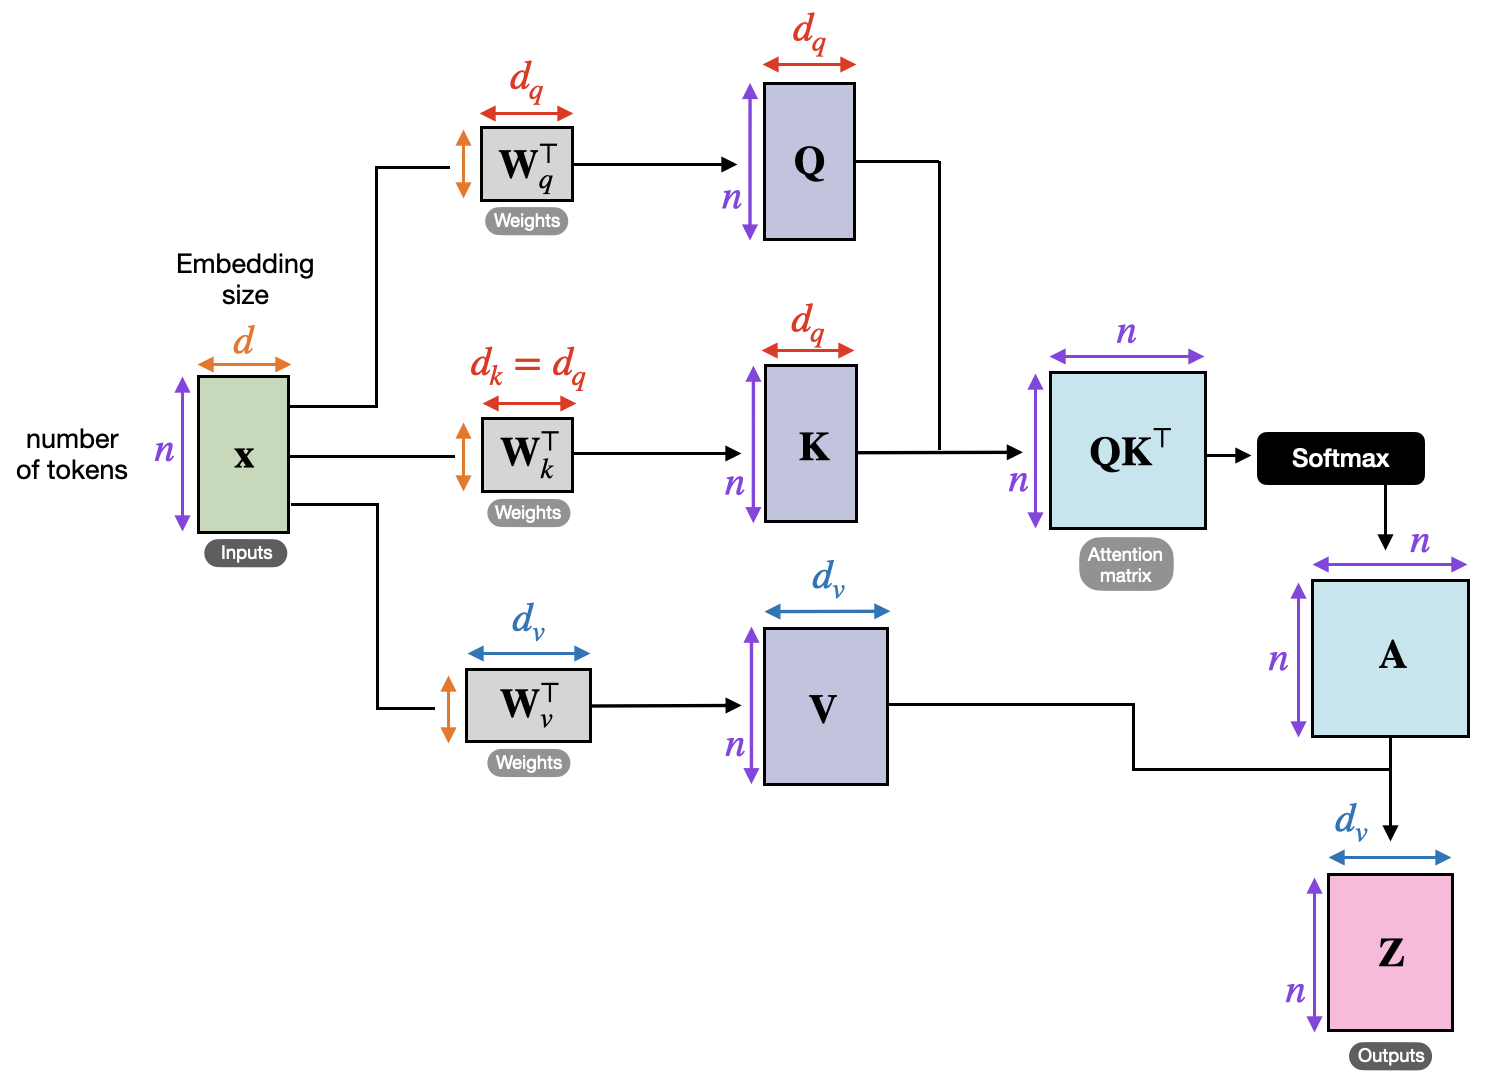

let $d_k = d_q = d_v = D$ to allow layers to stack

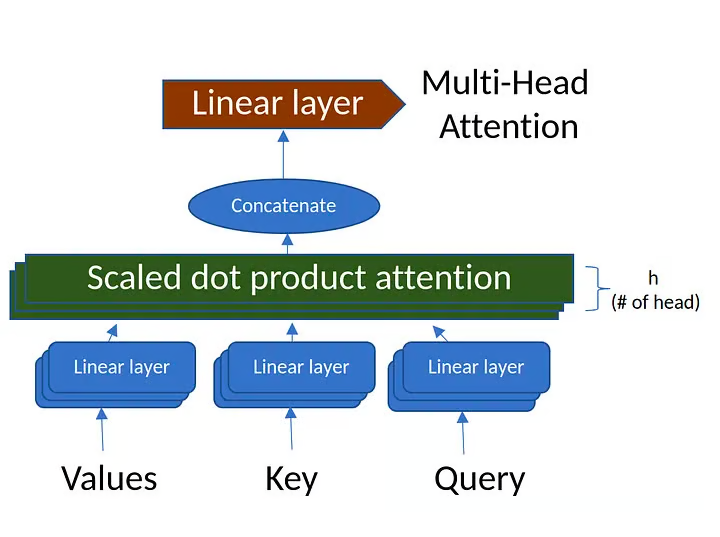

Instead of one head, use h heads with smaller per-head width $d_h=d_{model}/h$. Each head learns different relational subspaces as each head has its own $W_Q, ~ W_K, ~ W_V$ - can capture diverse patterns eg local vs global. Typically choose, $d_{model}=h~x~d_h, ~ d_k=d_v=d_h$. 
Concatenate head outputs and project back to $d_{model}$.

In [135]:
class MultiHeadAttention(nn.Module):
    """
    x: (B, N, D)
        N = num of features
        D = dim of model
    Returns: (B, N, D) where D = out_dim
    """
    def __init__(self,
            dim:int,
            num_heads:int,
            p_drop: float = 0.1
        ):
        super().__init__()

        self.dim=dim #dim of input
        self.num_heads=num_heads
        
        self.d_k=dim//num_heads #D//h = Dimension of each head's key, query, and value

        self.W_q=nn.Linear(dim,dim) 
        self.W_k=nn.Linear(dim,dim)
        self.W_v=nn.Linear(dim,dim)

        self.W_y=nn.Linear(dim,dim) #output transformation

        #dropout for attention probabilities - randomly zeroes fraction p and rescales rest by 1/(1-p) (Pytorch inverted dropout)
        #encourages model not to rely on single sharp attention pattern to improve generalisation
        self.attn_drop = nn.Dropout(p_drop)

        #feature dropout on per-token features produced by attention - randomly zeros elements of output vectors
        self.proj_drop = nn.Dropout(p_drop)

    def split_heads(self,x):
        batch,n,dim=x.size()
        x_split=x.reshape(batch,n,self.num_heads,self.d_k).transpose(-3,-2)
        return x_split

    def combine_heads(self,x_split):
        batch,num_heads,n,d_k=x_split.size()
        x_final = x_split.reshape(batch,n,self.dim)
        return x_final

    def scaled_dot_product_attention(self,q_split,k_split,v_split):
        #calculate attention weights
        # k.T flips all dims, including batch -> only need to transpose last two dims
        # k:(B,N,D) -> k.T:(D,N,B)
        # (B,N,D) @ (B,D,N) -> (B,N,N)

        k_split_T = k_split.transpose(-2,-1)

        attn_scores = torch.matmul(q_split,k_split_T) / math.sqrt(self.d_k)
        attn_probs = torch.softmax(attn_scores,dim=-1)
        attn_probs=self.attn_drop(attn_probs)
        y_split = torch.matmul(attn_probs,v_split)

        return y_split

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, N, E)
        q_split = self.split_heads(self.W_q(x))                     # (B, N, D) -> (B, h, N, D/h)
        k_split = self.split_heads(self.W_k(x))                     # (B, N, D) -> (B, h, N, D/h)
        v_split = self.split_heads(self.W_v(x))                     # (B, N, D) -> (B, h, N, D/h)

        y_split=self.scaled_dot_product_attention(q_split,k_split,v_split)
        y=self.W_y(self.combine_heads(y_split))
        y=self.proj_drop(y)

        return y

In [136]:
class FeedForward(nn.Module):
    def __init__(self, dim, dim_inner, p=0.1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim, dim_inner),
            nn.GELU(),
            nn.Dropout(p),
            nn.Linear(dim_inner, dim),
            nn.Dropout(p),
        )
    def forward(self, x): return self.layers(x)


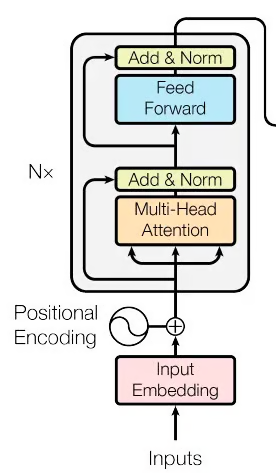

In [137]:
class TransformerLayer(nn.Module):
    """
    Standard transformer block with:
    - Multi-head attention
    - Layer normalization
    - Feed-forward network
    - Residual connections
    """

    def __init__(self,
            embed_dim:int =256,
            num_heads:int=16,
            ffn_dim_multiplier:float=2,
            p_drop: float = 0.2):
        
        super().__init__()

        dim_ff=embed_dim*ffn_dim_multiplier
        self.attn=MultiHeadAttention(dim=embed_dim,num_heads=num_heads,p_drop=p_drop)
        self.ff=FeedForward(dim=embed_dim,dim_inner=dim_ff)

        self.norm1=nn.LayerNorm(embed_dim)
        self.norm2=nn.LayerNorm(embed_dim)
        self.dropout=nn.Dropout(p_drop)

    def forward(self,x):
        attn_output=self.attn(x)
        drop=self.dropout(attn_output)

        #add & norm 1
        x=self.norm1(x+drop)

        # feed forward
        ff_output=self.ff(x)
        drop2=self.dropout(ff_output)

        #add & norm 2
        x=self.norm2(x+drop2)

        return x


In [138]:
class MultiLayerTransformerClassifier(nn.Module):
    def __init__(self, num_classes, embed_dim=256, num_heads=16,
                 ffn_dim_multiplier=4, num_layers=4, p_drop=0.1):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Linear(3, embed_dim),
            nn.GELU(),
            nn.Dropout(p_drop)
        )

        dpr = torch.linspace(0, 0.1, steps=num_layers).tolist()  # DropPath ramp
        self.blocks = nn.ModuleList([
            TransformerLayer(embed_dim, num_heads, ffn_dim_multiplier,
                             p_drop=p_drop)
            for i in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(2*embed_dim, num_classes)  # mean+max

    def forward(self, x):
        x = self.embed(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        #mean and max pooling
        x_mean = x.mean(dim=1)
        x_max  = x.amax(dim=1)
        x = torch.cat([x_mean, x_max], dim=-1)
        return self.head(x)


## test

In [139]:
#selected_classes = [0, 5, 6, 7, 8, 10, 19, 24, 26, 30, 32, 33, 34, 35, 37]
all_classes = [i for i in range(0,40)]
poor_classes = [24,39,1,21,36,12,23,3,10,15,11,38,29,13,27]
selected_classes = [i for i in all_classes if i not in poor_classes]
NUM_CLASSES = len(selected_classes)
train_dataset = ModelNetCustomDataset(train=True, classes=selected_classes, debug=False)
test_dataset = ModelNetCustomDataset(train=False, classes=selected_classes, debug=False)

BATCH_SIZE = 32
EPOCHS = 20
INPUT_SHAPE = (200, 3)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [140]:
# attention_model = MultiLayerTransformerClassifier(
#     num_classes=NUM_CLASSES, embed_dim=256, num_heads=16, num_layers=2,p_drop=0.1,ffn_dim_multiplier=4).to(device)
# (train_accs, test_accs,
#  train_losses, test_losses) = train_model(attention_model, epochs=EPOCHS,verbose=False)

C:\Users\snevi\AppData\Local\Temp\ipykernel_19160\2335877272.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt  = torch.load(CKPT_PATH, map_location=device)


Loaded from / saved to: saved_models\attention_9c4f19006d.ckpt.pt


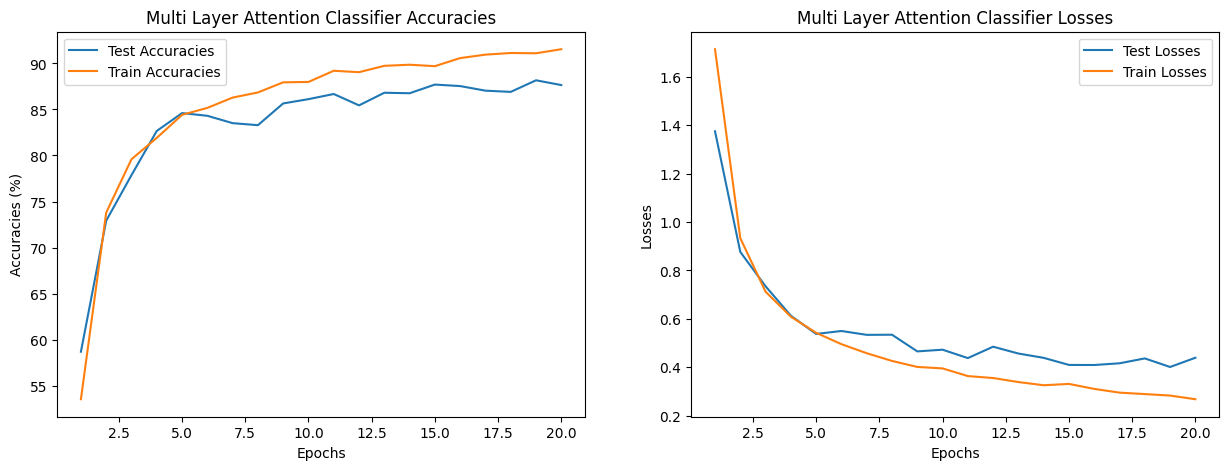

In [141]:
# --- minimal load-or-train (supports ckpt + legacy weights) -------------------
import os, json, hashlib, torch, numpy as np
from torch import nn

SAVE_DIR = "saved_models"; os.makedirs(SAVE_DIR, exist_ok=True)
FORCE_RETRAIN = False

MODEL_CFG = {
    "num_classes": NUM_CLASSES,
    "embed_dim": 256, "num_heads": 16, "num_layers": 2,
    "p_drop": 0.1, "ffn_dim_multiplier": 4,
    "selected_classes": list(selected_classes),
}

def _cfg_id(cfg):  # stable id tied to arch + label set
    return hashlib.sha1(json.dumps(cfg, sort_keys=True).encode()).hexdigest()[:10]

MID         = _cfg_id(MODEL_CFG)
CKPT_PATH   = os.path.join(SAVE_DIR, f"attention_{MID}.ckpt.pt")   # preferred (weights+history)
LEGACY_WTS  = os.path.join(SAVE_DIR, f"attention_{MID}.pt")        # old weights-only
LEGACY_META = os.path.join(SAVE_DIR, f"attention_{MID}.meta.json") # old meta

def build_model(cfg):
    return MultiLayerTransformerClassifier(
        num_classes=cfg["num_classes"],
        embed_dim=cfg["embed_dim"],
        num_heads=cfg["num_heads"],
        num_layers=cfg["num_layers"],
        p_drop=cfg["p_drop"],
        ffn_dim_multiplier=cfg["ffn_dim_multiplier"],
    ).to(device)

def _pad_series(arr, n):
    arr = list(arr) if isinstance(arr, (list, tuple)) else []
    if len(arr) < n: arr = arr + [np.nan] * (n - len(arr))
    else:            arr = arr[:n]
    return arr

def _normalize_history(h, epochs_fallback):
    """Ensure all curves exist and have equal length."""
    epochs = int(h.get("epochs", epochs_fallback))
    h_norm = {
        "epochs": epochs,
        "train_accs":   _pad_series(h.get("train_accs",   []), epochs),
        "test_accs":    _pad_series(h.get("test_accs",    []), epochs),
        "train_losses": _pad_series(h.get("train_losses", []), epochs),
        "test_losses":  _pad_series(h.get("test_losses",  []), epochs),
    }
    return h_norm

def get_or_train(cfg, force=False):
    # 1) Load new-style checkpoint (weights + history)
    if (not force) and os.path.exists(CKPT_PATH):
        ckpt  = torch.load(CKPT_PATH, map_location=device)
        model = build_model(cfg); model.load_state_dict(ckpt["model_state"]); model.eval()
        history = ckpt.get("history", {})
        return model, history, CKPT_PATH

    # 2) Fallback: legacy weights (+ optional meta check)
    if (not force) and os.path.exists(LEGACY_WTS):
        if os.path.exists(LEGACY_META):
            try:
                with open(LEGACY_META) as f: meta = json.load(f)
                if meta.get("num_classes") != cfg["num_classes"] or meta.get("selected_classes") != cfg["selected_classes"]:
                    print("[cache] legacy meta mismatches current config → retrain")
                    raise FileNotFoundError
            except Exception:
                pass
        model = build_model(cfg); model.load_state_dict(torch.load(LEGACY_WTS, map_location=device)); model.eval()
        # fabricate a 1-epoch history (pad with NaNs for missing series) so plots won’t crash
        tl, ta = test_step(model, test_dataloader, nn.CrossEntropyLoss(),
                           accuracy_fn, device=device, verbose=False)
        history = {
            "epochs": 1,
            "train_accs":   [np.nan],
            "test_accs":    [ta],
            "train_losses": [np.nan],
            "test_losses":  [tl],
        }
        return model, history, LEGACY_WTS

    # 3) Train and save a new-style checkpoint
    model = build_model(cfg)
    tr_accs, te_accs, tr_losses, te_losses = train_model(model, epochs=EPOCHS, verbose=False)
    ckpt = {"model_state": model.state_dict(),
            "history": {"epochs": EPOCHS, "train_accs": tr_accs, "test_accs": te_accs,
                        "train_losses": tr_losses, "test_losses": te_losses}}
    torch.save(ckpt, CKPT_PATH)
    return model, ckpt["history"], CKPT_PATH
# ------------------------------------------------------------------------------

attention_model, history, ckpt_path = get_or_train(MODEL_CFG, force=FORCE_RETRAIN)
history = _normalize_history(history, epochs_fallback=EPOCHS)
print(f"Loaded from / saved to: {ckpt_path}")

# Safe for plotting (lengths are aligned to history['epochs'])
plot_acc_losses(
    model_name="Multi Layer Attention Classifier",
    train_accs=history["train_accs"],
    test_accs=history["test_accs"],
    train_losses=history["train_losses"],
    test_losses=history["test_losses"],
    epochs=history["epochs"]
)


## eval

In [142]:
# Names aligned to remapped labels 0..NUM_CLASSES-1
selected_names = [test_dataset.class_names[test_dataset.reverse_mapping[i]]
                  for i in range(NUM_CLASSES)]

In [143]:
from __future__ import annotations

import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

model=attention_model.eval()
# OPTIONAL: load a trained checkpoint
# model.load_state_dict(torch.load("saved_objects/model_1_weights.pth", map_location=device))

# ----- overall metrics -----
@torch.no_grad()
def overall_metrics(model, loader):
    ys, yh = [], []
    for X, y, _ in loader:
        X = X.to(device)
        logits = model(X)
        yh.append(torch.argmax(logits, dim=1).cpu().numpy())
        ys.append(y.numpy())
    y_true = np.concatenate(ys); y_pred = np.concatenate(yh)

    acc = (y_true == y_pred).mean() * 100
    cm  = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    # make the mapping explicit to avoid any ambiguity
    rep = classification_report(
        y_true, y_pred,
        labels=list(range(NUM_CLASSES)),
        target_names=selected_names,
        digits=3, zero_division=0
    )
    return acc, cm, rep


def plot_confusion(cm, normalize=True):
    if normalize:
        cm = cm / cm.sum(axis=1, keepdims=True).clip(min=1)
    fig, ax = plt.subplots(figsize=(9,9))
    im = ax.imshow(cm, interpolation="nearest")
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(NUM_CLASSES), yticks=np.arange(NUM_CLASSES),
           xticklabels=selected_names, yticklabels=selected_names,
           ylabel="True", xlabel="Predicted", title="Confusion Matrix")
    ax.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    return fig

In [144]:
import matplotlib
from matplotlib.lines import Line2D

def tsne_pooled_features(model, loader, num_points=2000,
                         show_legend=True, legend_outside=True,
                         save_legend_path=None, inline_labels=False):
    pooled_list, labels = [], []
    captured = {}
    def hook(mod, inp, out):
        captured["pooled"] = inp[0].detach().cpu()
    handle = model.head.register_forward_hook(hook)

    with torch.no_grad():
        seen = 0
        for X, y, _ in loader:
            X = X.to(device)
            _ = model(X)
            pooled_list.append(captured["pooled"].numpy())
            labels.append(y.numpy())
            seen += X.size(0)
            if seen >= num_points:
                break

    handle.remove()
    Xp = np.concatenate(pooled_list)[:num_points]
    yp = np.concatenate(labels)[:num_points]

    # t-SNE
    emb = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=30).fit_transform(Xp)

    # Discrete colormap + normalization across integer class ids
    K = NUM_CLASSES
    cmap = matplotlib.cm.get_cmap("tab20", K)  # K colors
    norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5, K + 0.5, 1), cmap.N)

    plt.figure(figsize=(8,6))
    sc = plt.scatter(emb[:,0], emb[:,1], c=yp, s=10, alpha=0.7, cmap=cmap, norm=norm)
    plt.title("t-SNE of pooled features"); plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.tight_layout()

    # Build legend handles once
    handles = [Line2D([0],[0], marker='o', linestyle='', markersize=6,
                      markerfacecolor=cmap(i), markeredgecolor='none',
                      label=selected_names[i]) for i in range(K)]

    if show_legend and legend_outside:
        # compact legend placed outside
        lgd = plt.legend(handles=handles, loc="center left", bbox_to_anchor=(1.02, 0.5),
                         frameon=False, title="Classes", ncol=1)
        plt.tight_layout(rect=[0,0,0.82,1])
    elif show_legend:
        plt.legend(handles=handles, loc="best", frameon=False, ncol=2)

    return plt.gcf()

In [145]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import numpy as np
import torch
import torch.nn.functional as F

def _dataset_tensors(dataset):
    """Return (x, y, names_list) tensors from a ModelNetCustomDataset."""
    x_data = dataset.x          # (N, 200, 3)
    y_data = dataset.y          # (N,)
    try:
        # selected_names already built earlier; else remap from dataset
        names = selected_names
    except NameError:
        # Fallback: compute names aligned to remapped labels 0..K-1
        K = int(y_data.max().item()) + 1
        names = [dataset.class_names[dataset.reverse_mapping[i]] for i in range(K)]
    return x_data, y_data, names


In [146]:
def plot_3d_object_from_dataset(dataset, object_idx: int = 0, class_num: int | None = None,
                                elev: int = 20, azim: int = 45):
    """
    Plot one point-cloud from a ModelNetCustomDataset.
    If class_num is provided, shows the first object of that class.
    """
    x_data, y_data, names = _dataset_tensors(dataset)

    if class_num is not None:
        idxs = (y_data == class_num).nonzero(as_tuple=True)[0]
        if len(idxs) == 0:
            print(f"No objects found for class {class_num}")
            return
        object_idx = int(idxs[0].item())

    pts = x_data[object_idx]              # (200, 3)
    label = int(y_data[object_idx].item())
    cls_name = names[label] if label < len(names) else f"class_{label}"

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                    c=pts[:, 2], cmap='viridis', s=16, alpha=0.8)
    fig.colorbar(sc, ax=ax, shrink=0.7, label='z')
    ax.set_title(f'Object idx={object_idx} | Class {label}: {cls_name}')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.show()


In [147]:
def plot_all_classes_from_dataset(dataset, classes_to_plot=None, num_objects_per_class=1,
                                  figsize=(20, 14), max_cols=8, elev: int = 20, azim: int = 45):
    """
    Show multiple objects for many classes in a grid of 3D subplots.
    """
    x_data, y_data, names = _dataset_tensors(dataset)
    all_classes = torch.unique(y_data).tolist()

    if classes_to_plot is None:
        classes_to_plot = all_classes
    else:
        classes_to_plot = [c for c in classes_to_plot if c in all_classes]

    # Collect example indices per class
    per_class_indices = {}
    for c in sorted(classes_to_plot):
        idxs = (y_data == c).nonzero(as_tuple=True)[0]
        if len(idxs) == 0: 
            continue
        take = min(num_objects_per_class, len(idxs))
        per_class_indices[c] = idxs[:take].tolist()

    total = sum(len(v) for v in per_class_indices.values())
    if total == 0:
        print("Nothing to plot.")
        return per_class_indices

    n_cols = min(max_cols, total)
    n_rows = int(np.ceil(total / n_cols))

    fig = plt.figure(figsize=figsize)
    fig.suptitle(f'3D samples ({len(per_class_indices)} classes, {num_objects_per_class}/class)',
                 fontsize=16, fontweight='bold')

    k = 1
    for c in sorted(per_class_indices.keys()):
        cname = names[c] if c < len(names) else f"class_{c}"
        for obj_idx in per_class_indices[c]:
            pts = x_data[obj_idx]
            ax = fig.add_subplot(n_rows, n_cols, k, projection='3d')
            sc = ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                            c=pts[:, 2], cmap='plasma', s=10, alpha=0.9)
            ax.set_title(f'{c}: {cname}\n(idx {obj_idx})', fontsize=9)
            ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
            ax.tick_params(labelsize=6)
            ax.view_init(elev=elev, azim=azim)
            k += 1

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    #print(f"Plotted {total} objects across {len(per_class_indices)} classes.")
    #return per_class_indices


Top-1 accuracy: 5.02%
              precision    recall  f1-score   support

    airplane      0.941     0.960     0.950       100
         bed      0.832     0.990     0.904       100
   bookshelf      0.835     0.960     0.893       100
      bottle      0.885     0.770     0.824       100
        bowl      0.586     0.850     0.694        20
         car      0.900     0.990     0.943       100
       chair      0.813     1.000     0.897       100
        cone      0.941     0.800     0.865        20
     dresser      0.963     0.907     0.934        86
   glass_box      1.000     0.870     0.930       100
      guitar      0.927     0.890     0.908       100
    keyboard      0.783     0.900     0.837        20
        lamp      0.800     0.400     0.533        20
      laptop      0.528     0.950     0.679        20
     monitor      0.990     0.950     0.969       100
       piano      0.878     0.790     0.832       100
       plant      0.802     0.810     0.806       100
  ran

C:\Users\snevi\AppData\Local\Temp\ipykernel_19160\1553141108.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("tab20", K)  # K colors


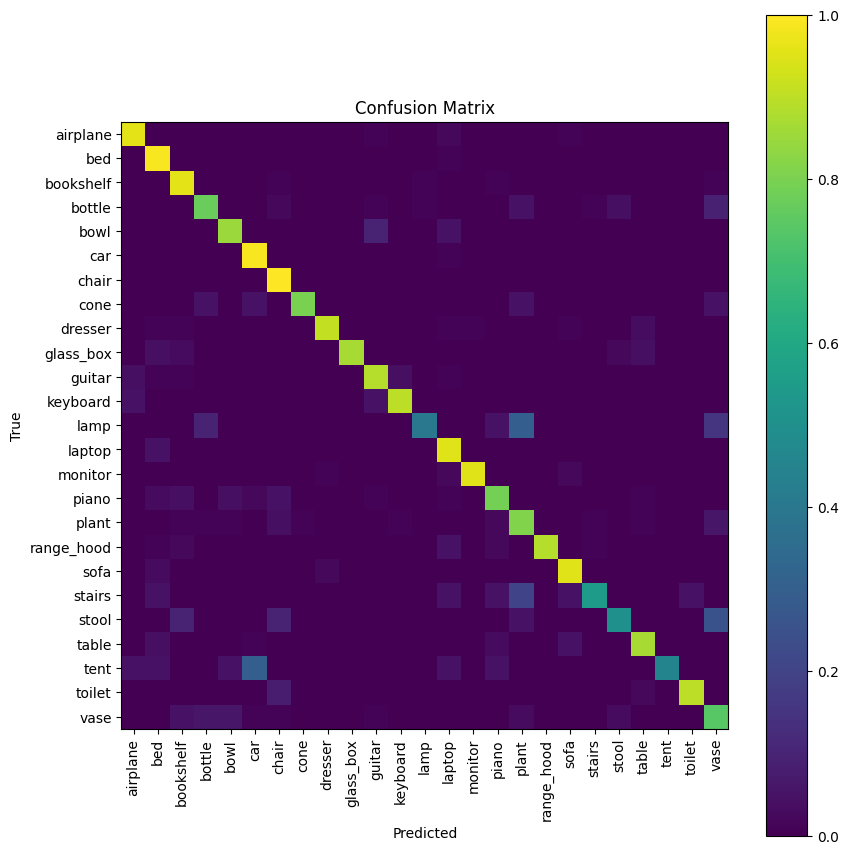

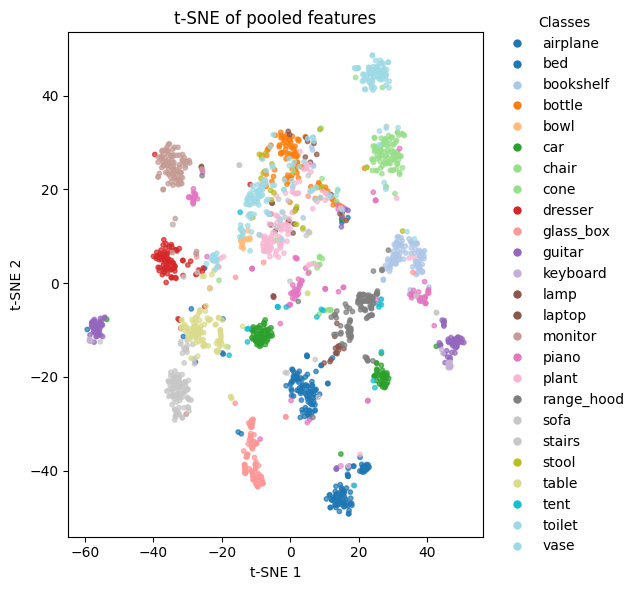

In [148]:
acc, cm, rep = overall_metrics(model, test_dataloader)
print(f"Top-1 accuracy: {acc:.2f}%")
print(rep)
plot_confusion(cm, normalize=True)
tsne_pooled_features(model, test_dataloader, num_points=2000,
                     show_legend=True, legend_outside=True)
plt.show()


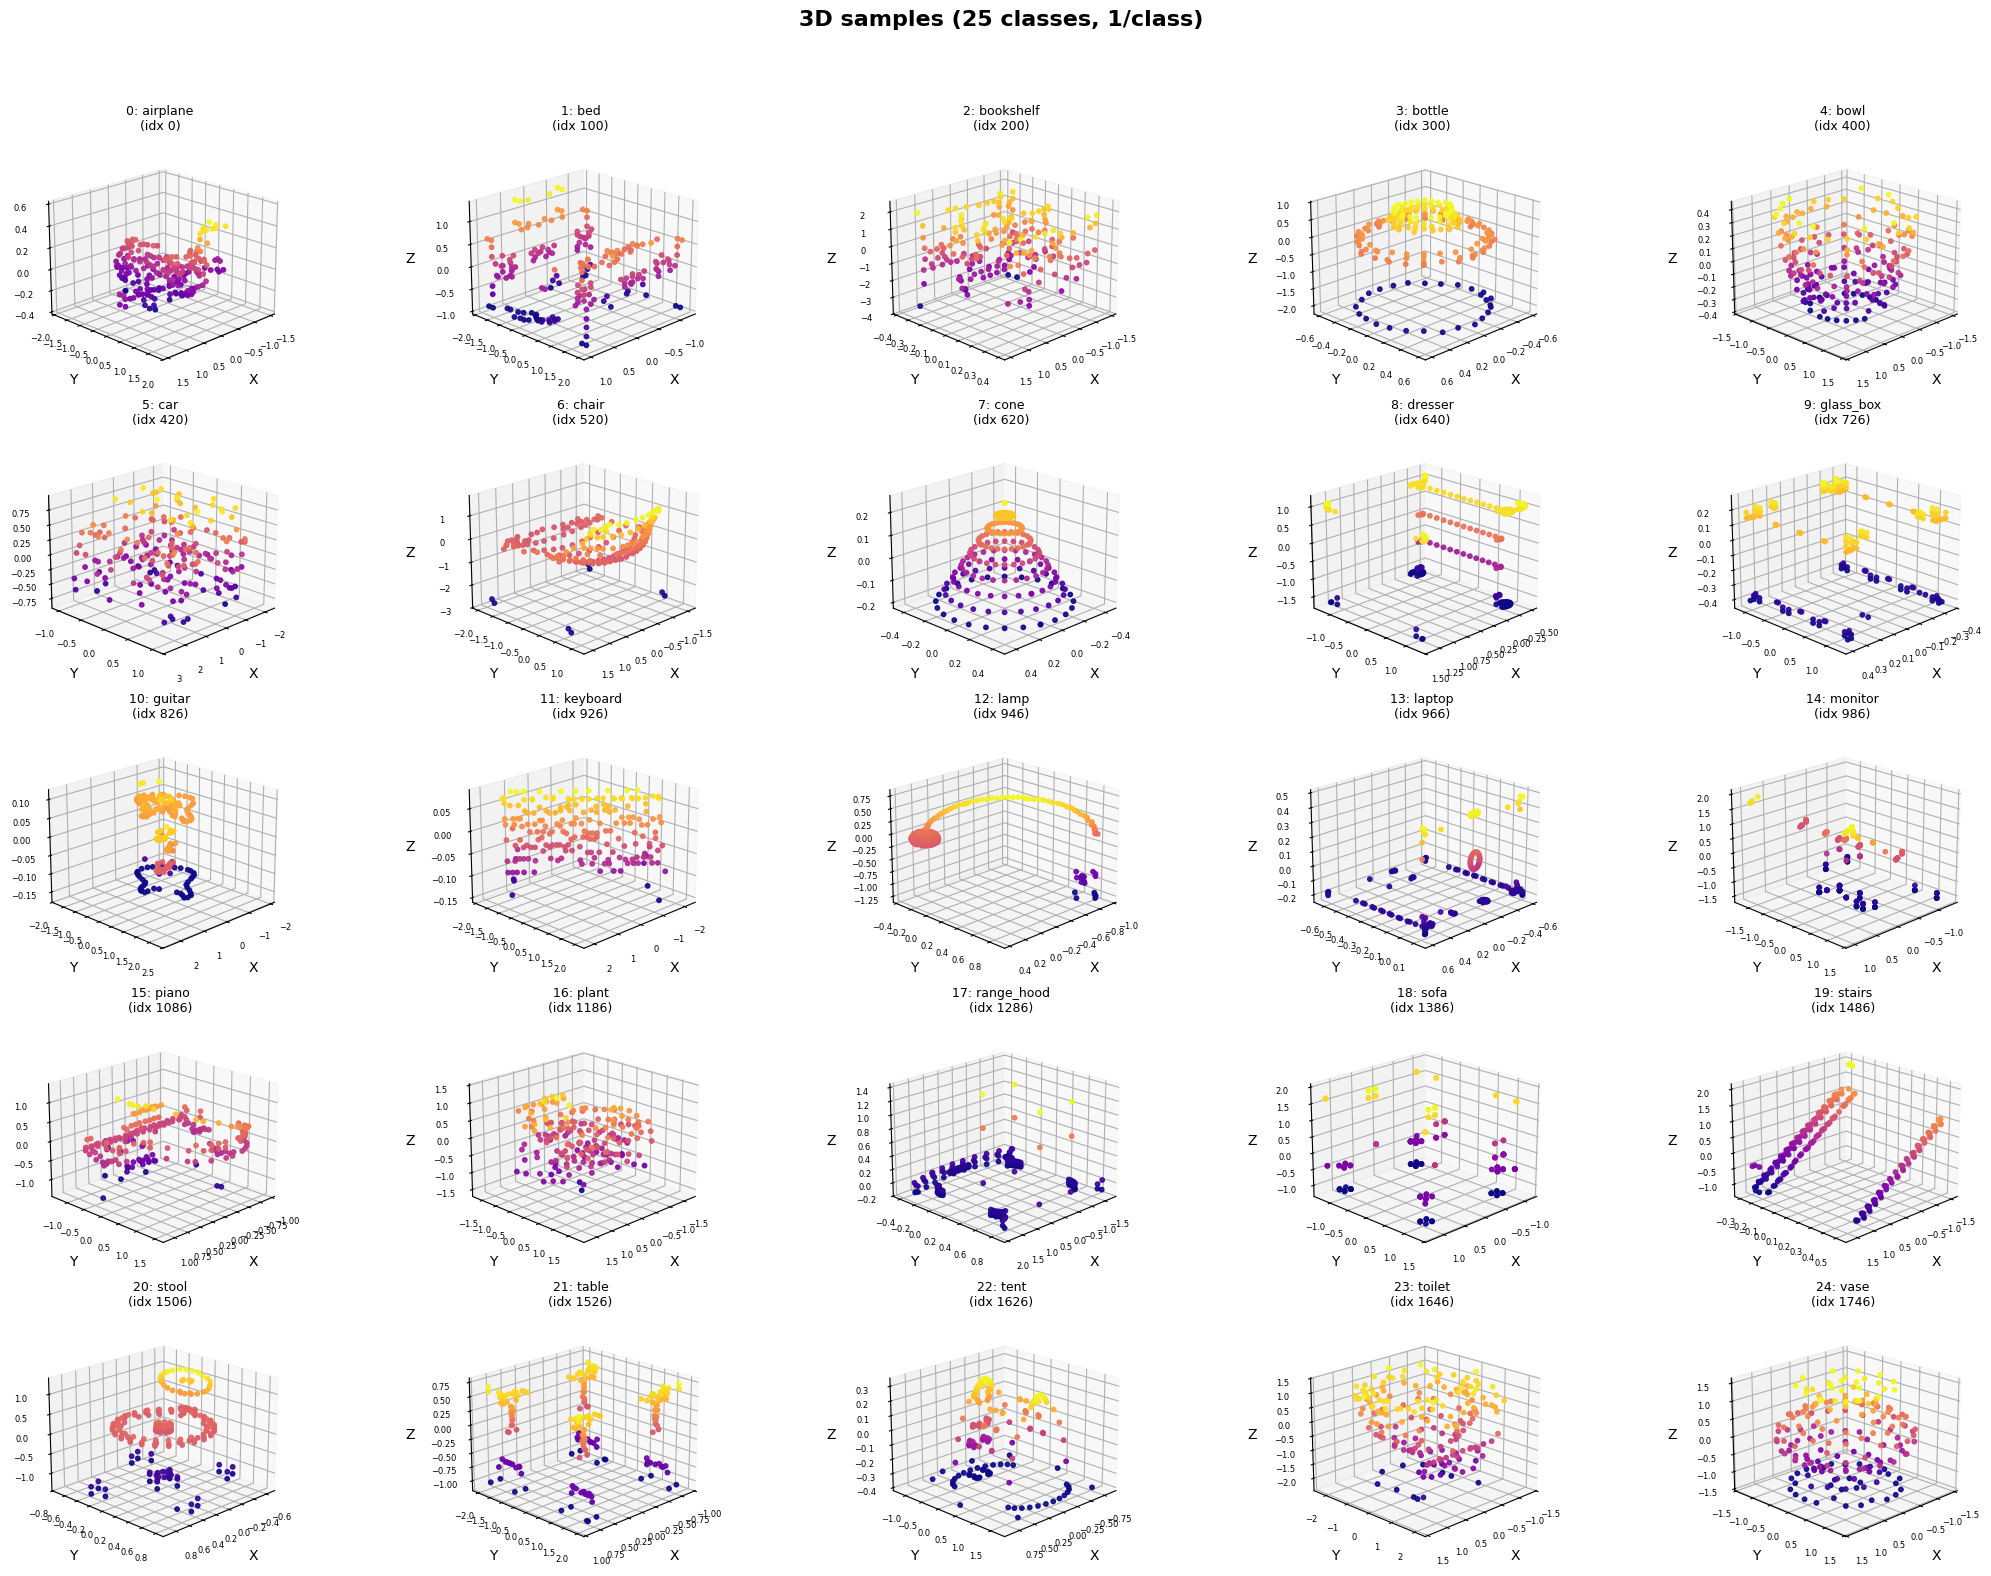

In [149]:
# Single object / by class
# plot_3d_object_from_dataset(test_dataset, object_idx=10)
# plot_3d_object_from_dataset(test_dataset, class_num=3)

# Grid across classes (your selected subset)
plot_all_classes_from_dataset(test_dataset, classes_to_plot=list(range(NUM_CLASSES)),
                              num_objects_per_class=1, figsize=(22, 16), max_cols=5)